In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchsummary import summary

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('./human_poses_data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [5]:
categories = pd.read_csv('./human_poses_data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [6]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [7]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
RANDOM_SEED = 52
generator = torch.Generator().manual_seed(RANDOM_SEED)

In [10]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 8


In [11]:
dataset = HumanPoseDataset(
    img_dir='./human_poses_data/img_train',
    csv_file='./human_poses_data/train_answers.csv',
    transform=transform
)

train_dataset, val_dataset = random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))], generator)

In [12]:
def show_images_row(images, labels, size=(2, 2)):
    """
    Параметры:
    - images: список тензоров изображений
    - labels: список меток
    - size: кортеж (ширина, высота) изображения
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(size[0] * num_images, size[1]))
    if num_images == 1:
        axes = [axes]  # Если одно изображение, делаем axes списком

    for img, label, ax in zip(images, labels, axes):
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'Label: {id_to_category[label]}')
        ax.axis('off')  # Убираем оси

    plt.tight_layout()
    plt.show()

In [12]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label = dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2102921..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input

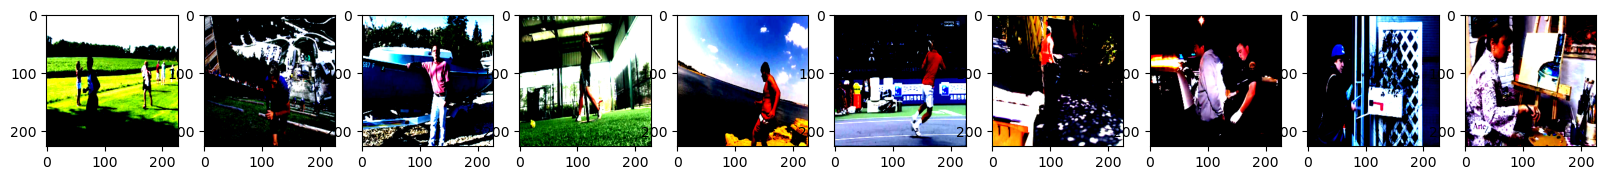

In [14]:
show_images_with_labels(train_dataset, id_to_category)

In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:
len(id_to_category)

20

In [17]:
summary(AlexNet(20).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [18]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
import tqdm

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [24]:
model = AlexNet(20).to(device)

In [25]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

In [26]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=4, tm_hour=20, tm_min=8, tm_sec=50, tm_wday=2, tm_yday=339, tm_isdst=0)

In [27]:
# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    # Возвращаем результаты: значение функции потерь, выходы модели и метки
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    # Если файл уже существует, загружаем его (например, для продолжения тренировки)
    metrics_df = pd.read_csv(metrics_path)
else:
    # Создаём новый DataFrame, если файла ещё нет
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настраиваем сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,  # Что сохранять
    DiskSaver("./checkpoints" + path_suf, create_dir=True, require_empty=False),  # Диск-сохранитель
    n_saved=3,  # Сохранять только последние 3 чекпоинта
    filename_prefix="best",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг (номер итерации)
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]
    
    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]
    
    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем таблицу в CSV
    
    # Сохраняем модель
    handler(evaluator)

In [ ]:
trainer.run(train_loader, max_epochs=100)

C:\Users\Vlad\AppData\Local\Temp\ipykernel_24564\2395987862.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


Epoch 1: Train Loss: 2.6110, Train Accuracy: 0.1917, Validation Loss: 2.5423, Validation Accuracy: 0.2021


Epoch 2: Train Loss: 2.5473, Train Accuracy: 0.2032, Validation Loss: 2.5402, Validation Accuracy: 0.2021


Epoch 3: Train Loss: 2.5444, Train Accuracy: 0.2038, Validation Loss: 2.5384, Validation Accuracy: 0.2021


Epoch 4: Train Loss: 2.5454, Train Accuracy: 0.2032, Validation Loss: 2.5349, Validation Accuracy: 0.2021


Epoch 5: Train Loss: 2.5427, Train Accuracy: 0.2032, Validation Loss: 2.5324, Validation Accuracy: 0.2021


Epoch 6: Train Loss: 2.5430, Train Accuracy: 0.2032, Validation Loss: 2.5385, Validation Accuracy: 0.2021


Epoch 7: Train Loss: 2.5424, Train Accuracy: 0.2032, Validation Loss: 2.5341, Validation Accuracy: 0.2021


Epoch 8: Train Loss: 2.5416, Train Accuracy: 0.2032, Validation Loss: 2.5344, Validation Accuracy: 0.2021


Epoch 9: Train Loss: 2.5418, Train Accuracy: 0.2032, Validation Loss: 2.5338, Validation Accuracy: 0.2021


Epoch 10: Train Loss: 2.5411, Train Accuracy: 0.2032, Validation Loss: 2.5336, Validation Accuracy: 0.2021


Epoch 11: Train Loss: 2.5406, Train Accuracy: 0.2032, Validation Loss: 2.5336, Validation Accuracy: 0.2021


Epoch 12: Train Loss: 2.5407, Train Accuracy: 0.2032, Validation Loss: 2.5313, Validation Accuracy: 0.2021


Epoch 13: Train Loss: 2.5400, Train Accuracy: 0.2032, Validation Loss: 2.5319, Validation Accuracy: 0.2021


Epoch 14: Train Loss: 2.5396, Train Accuracy: 0.2032, Validation Loss: 2.5350, Validation Accuracy: 0.2021


Epoch 15: Train Loss: 2.5402, Train Accuracy: 0.2032, Validation Loss: 2.5319, Validation Accuracy: 0.2021


Epoch 16: Train Loss: 2.5399, Train Accuracy: 0.2032, Validation Loss: 2.5327, Validation Accuracy: 0.2021


Epoch 17: Train Loss: 2.5401, Train Accuracy: 0.2032, Validation Loss: 2.5313, Validation Accuracy: 0.2021


Epoch 18: Train Loss: 2.5398, Train Accuracy: 0.2032, Validation Loss: 2.5321, Validation Accuracy: 0.2021


Epoch 19: Train Loss: 2.5395, Train Accuracy: 0.2032, Validation Loss: 2.5330, Validation Accuracy: 0.2021


Epoch 20: Train Loss: 2.5403, Train Accuracy: 0.2032, Validation Loss: 2.5349, Validation Accuracy: 0.2021


Epoch 21: Train Loss: 2.5394, Train Accuracy: 0.2032, Validation Loss: 2.5323, Validation Accuracy: 0.2021


Epoch 22: Train Loss: 2.5390, Train Accuracy: 0.2032, Validation Loss: 2.5324, Validation Accuracy: 0.2021


Epoch 23: Train Loss: 2.5391, Train Accuracy: 0.2032, Validation Loss: 2.5323, Validation Accuracy: 0.2021


Epoch 24: Train Loss: 2.5395, Train Accuracy: 0.2032, Validation Loss: 2.5328, Validation Accuracy: 0.2021


Epoch 25: Train Loss: 2.5394, Train Accuracy: 0.2032, Validation Loss: 2.5325, Validation Accuracy: 0.2021


Epoch 26: Train Loss: 2.5385, Train Accuracy: 0.2032, Validation Loss: 2.5332, Validation Accuracy: 0.2021


Epoch 27: Train Loss: 2.5391, Train Accuracy: 0.2032, Validation Loss: 2.5323, Validation Accuracy: 0.2021


Epoch 28: Train Loss: 2.5391, Train Accuracy: 0.2032, Validation Loss: 2.5321, Validation Accuracy: 0.2021


Epoch 29: Train Loss: 2.5385, Train Accuracy: 0.2032, Validation Loss: 2.5348, Validation Accuracy: 0.2021


Epoch 30: Train Loss: 2.5390, Train Accuracy: 0.2032, Validation Loss: 2.5314, Validation Accuracy: 0.2021


Epoch 31: Train Loss: 2.5384, Train Accuracy: 0.2032, Validation Loss: 2.5320, Validation Accuracy: 0.2021


Epoch [32/100]: [165/174]  95%|█████████▍ [03:39<00:12]